In [65]:
%matplotlib inline
import numpy as np
from math import sqrt
from math import exp
from math import pi
from random import seed
import pandas as pd
import seaborn as sb
from csv import reader
import matplotlib.pyplot as plt
plt.figure(figsize=(15,12))

<Figure size 1080x864 with 0 Axes>

<Figure size 1080x864 with 0 Axes>

In [44]:
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [45]:
df=pd.read_csv("data.csv")
df.head()             #to extract first five columns

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [48]:
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

In [50]:
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

In [61]:
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [63]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [67]:
def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated

In [69]:
def predict(summaries, row):
	probabilities = calculate_class_probabilities(summaries, row)
	best_label, best_prob = None, -1
	for class_value, probability in probabilities.items():
		if best_label is None or probability > best_prob:
			best_prob = probability
			best_label = class_value
	return best_label

In [71]:
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities
 

In [3]:
df.tail()   #to extract last five columns

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


In [4]:
df.info()   #information of column data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


In [5]:
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [6]:
type(df.describe())

pandas.core.frame.DataFrame

In [7]:
#check types of species
df['Species'].value_counts()

Iris-versicolor    50
Iris-virginica     50
Iris-setosa        50
Name: Species, dtype: int64

In [8]:
df.shape

(150, 6)

In [9]:
#dropping the non-required columns
df1=df.drop(['Id'],axis=1)
df1.shape

(150, 5)

## Data Visualisation

#### From the pair plot, it will be clear that the relationship between pairs of features are similar or different for the species

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


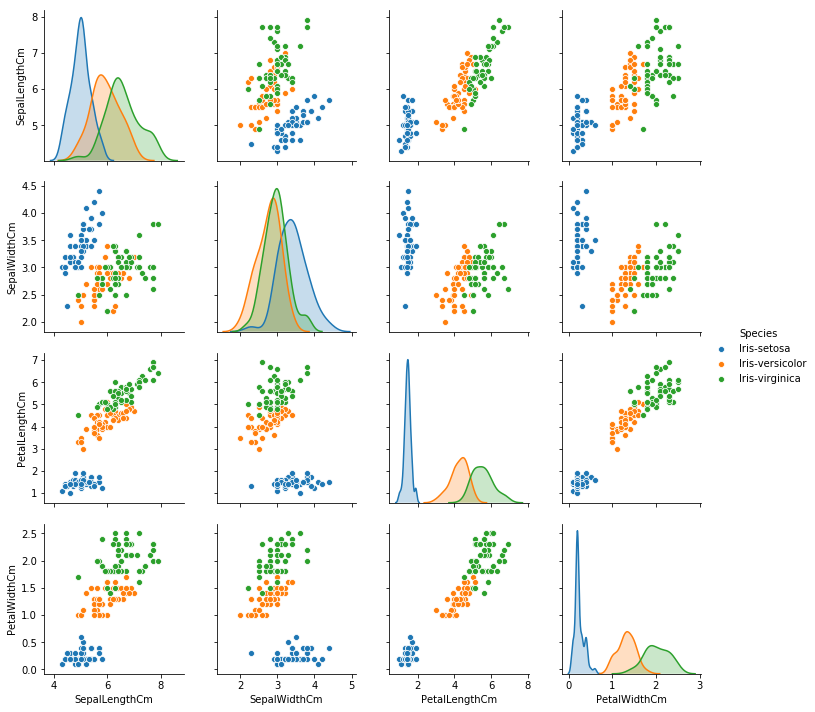

In [10]:
sb.pairplot(df1,hue='Species')
plt.show()

### Conclusion: The diagonal plot shows the probability distribution of a single variable, upper triangle and lower triangle shows scatter plot, i.e, relation between the features and upper triangle and lower triangle are mirror images of each other### 

#### Studying the scatter plots

In [11]:
seto=df1.loc[df1["Species"]=="Iris-setosa"]
vir=df1.loc[df1["Species"]=="Iris-virginica"]
ver=df1.loc[df1["Species"]=="Iris-versicolor"]


In [12]:
seto.shape,vir.shape,ver.shape

((50, 5), (50, 5), (50, 5))

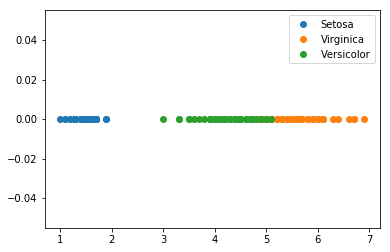

In [13]:
plt.plot(seto["PetalLengthCm"],np.zeros_like(seto["PetalLengthCm"]),'o',label="Setosa")
plt.plot(vir["PetalLengthCm"],np.zeros_like(vir["PetalLengthCm"]),'o',label="Virginica")
plt.plot(ver["PetalLengthCm"],np.zeros_like(ver["PetalLengthCm"]),'o',label="Versicolor")
plt.legend()


#### from the 1-d scatter plot we can conclude that virginica and versicolor are more alike to each other

## 2-D Scatter plot

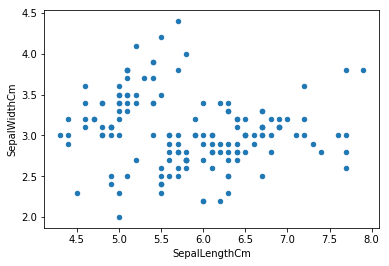

In [14]:
df1.plot(kind='scatter',x='SepalLengthCm',y='SepalWidthCm')
plt.show()             #this graph does not give any meaningful information. Therefore, we will use seaborn

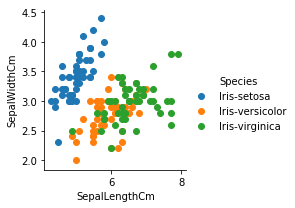

In [15]:
sb.FacetGrid(df1,hue='Species').map(plt.scatter,'SepalLengthCm','SepalWidthCm').add_legend()

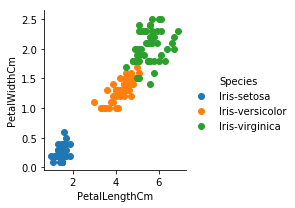

In [16]:
sb.FacetGrid(df1,hue='Species').map(plt.scatter,'PetalLengthCm','PetalWidthCm').add_legend()

#### From the 2-d graph it can be concluded that sepal length and sepal width of versicolor and virginica are almost collapsing while they can be differentiated on the basis of petal length and petal width.

## HISTOGRAM and PDE (Probabiity Distribution Estimation)

#### Histogram is an accurate graphical representation of the distribution of numerical data. It is an estimate of probablity distriution of a continuous variable

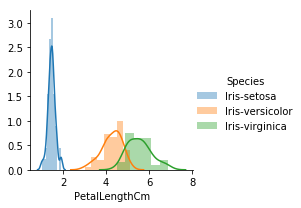

In [17]:
sb.FacetGrid(df1,hue='Species').map(sb.distplot,'PetalLengthCm').add_legend()

[]

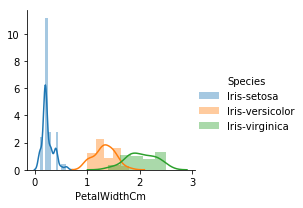

In [18]:
sb.FacetGrid(df1,hue='Species').map(sb.distplot,'PetalWidthCm').add_legend()
plt.plot()

### Conclusion: As we compare petal length and petal width, petal length of setosa are better separable than petal width. Also, there is overlap between versicolor and virginica

[]

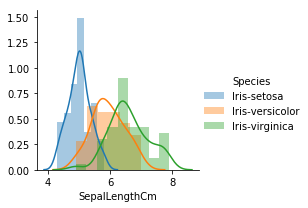

In [19]:
sb.FacetGrid(df1,hue='Species').map(sb.distplot,'SepalLengthCm').add_legend()
plt.plot()

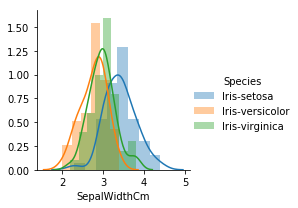

In [20]:
sb.FacetGrid(df1,hue='Species').map(sb.distplot,'SepalWidthCm').add_legend()

#### We can't separate any class on the basis of sepal length and sepal width because they are overlapping

## Violin Plot

In [21]:
sb.set_style("whitegrid")
#set grid as white

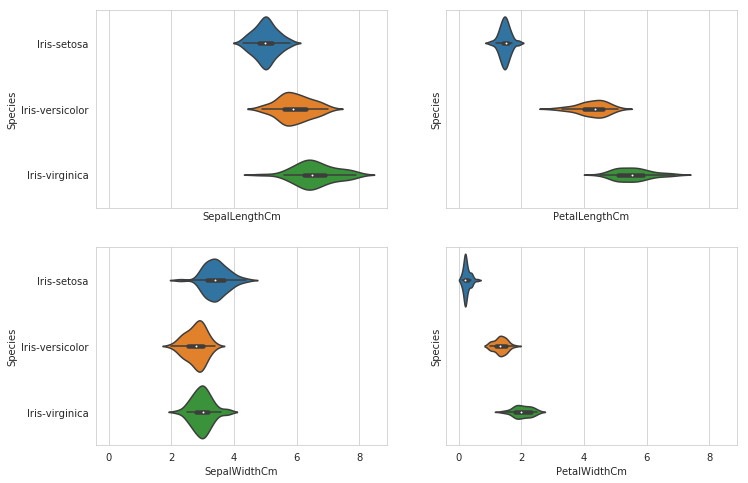

In [22]:
fig,axes=plt.subplots(2,2,sharex=True,sharey=True,figsize=(11.5,8))
sb.violinplot(x='SepalLengthCm',y='Species',data=df1,ax=axes[0,0])
sb.violinplot(x='PetalLengthCm',y='Species',data=df1,ax=axes[0,1])
sb.violinplot(x='SepalWidthCm',y='Species',data=df1,ax=axes[1,0])
sb.violinplot(x='PetalWidthCm',y='Species',data=df1,ax=axes[1,1])

#violin plot on 2x2 subplots


## Conclusion: Violin plot is a method of plotting numeric data. It shows rotated kernel density plot on each side. Usually, PDE of data at different values smoothed by a KDE

# CLASSIFICATION ALGORITHM

In [23]:
from sklearn import metrics                                       #used to find accuracy
from sklearn.linear_model import LogisticRegression               #used for classification
from sklearn.model_selection import train_test_split              #used for splitting the data

In [24]:
X=df1.drop('Species',axis=1)
y=df1["Species"]
X.shape,y.shape

((150, 4), (150,))

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=10)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((90, 4), (60, 4), (90,), (60,))

In [26]:
lr=LogisticRegression(multi_class='auto',solver='liblinear')
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
metrics.accuracy_score(y_pred,y_test)

0.8

In [27]:
lr.predict([[4.7,2.9,1.6,0.2]])

array(['Iris-setosa'], dtype=object)

In [28]:
print(lr.predict_proba([[5.9,1.9,1.6,0.2]]))

[[4.95482383e-01 5.04237834e-01 2.79782879e-04]]


In [29]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [30]:
lr.score(X_test,y_test)

0.8

In [31]:
lr.sparsify()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
lr.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [33]:
lr.coef_.toarray()

array([[ 0.3367472 ,  1.35456416, -2.01459149, -0.94686153],
       [ 0.68766128, -1.71873951,  0.06671239, -0.62524156],
       [-1.43831595, -1.13462969,  2.10942653,  1.86256222]])

In [34]:
lr.intercept_

array([ 0.22212861,  0.68618642, -0.8110032 ])

In [35]:
lr.n_iter_

array([7], dtype=int32)

In [36]:
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)
        return(predictions)

In [72]:
# Test Naive Bayes on Iris Dataset
seed(1)
filename = 'data.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset,i)
# convert class column to integers
str_column_to_int(dataset, len((dataset[0])-1)
# evaluate algorithm
n_folds=5
scores=evaluate_algorithm(dataset, naive_bayes, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

SyntaxError: invalid syntax (<ipython-input-72-9b8ffc8efc58>, line 10)

In [79]:
from csv import reader
from random import seed
from random import randrange
from math import sqrt
from math import exp
from math import pi

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split the dataset by class values, returns a dictionary
def separate_by_class(dataset):
	separated = dict()
	for i in range(len(dataset)):
		vector = dataset[i]
		class_value = vector[-1]
		if (class_value not in separated):
			separated[class_value] = list()
		separated[class_value].append(vector)
	return separated

# Calculate the mean of a list of numbers
def mean(numbers):
	return sum(numbers)/float(len(numbers))

# Calculate the standard deviation of a list of numbers
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
	return sqrt(variance)

# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
	summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
	del(summaries[-1])
	return summaries

# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
	separated = separate_by_class(dataset)
	summaries = dict()
	for class_value, rows in separated.items():
		summaries[class_value] = summarize_dataset(rows)
	return summaries

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
	exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
	return (1 / (sqrt(2 * pi) * stdev)) * exponent

# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
	total_rows = sum([summaries[label][0][2] for label in summaries])
	probabilities = dict()
	for class_value, class_summaries in summaries.items():
		probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
		for i in range(len(class_summaries)):
			mean, stdev, _ = class_summaries[i]
			probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
	return probabilities

# Predict the class for a given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
            return best_label

# Naive Bayes Algorithm
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)
        return(predictions)

# Test Naive Bayes on Iris Dataset
seed(1)
filename = 'data.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len((dataset[0])-1)
# evaluate algorithm
n_folds = 5
scores = evaluate_algorithm(dataset, naive_bayes, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

SyntaxError: invalid syntax (<ipython-input-79-023878e8a5f8>, line 154)